In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_validate
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import ShuffleSplit
from sklearn.feature_selection import RFE
import matplotlib.pyplot as plt
from sklearn.svm import SVR
from sklearn.metrics import mean_absolute_error, make_scorer, mean_squared_error
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import Lasso

In [2]:
#create cross validation object
cv = ShuffleSplit(n_splits=10, test_size=0.10, random_state=0)

In [3]:
# Load in merged community college data
url = 'https://github.com/BrownRegaSterlingHeinen/PostsecondaryAttainment/blob/master/2016/Machine%20Learning%20Datasets/NCCCData_withHS_ML.csv?raw=true'
NCCCData = pd.read_csv(url)

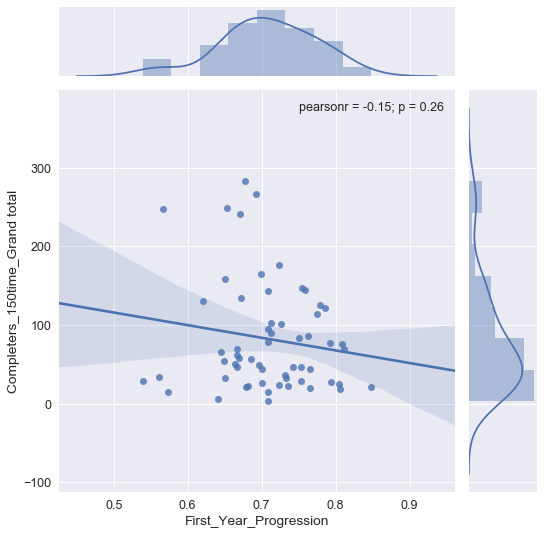

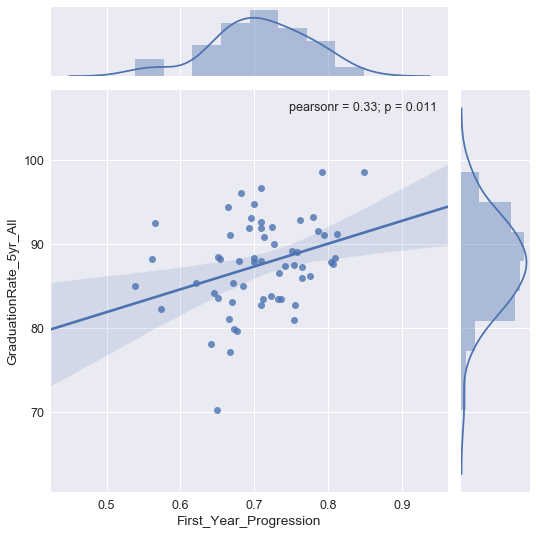

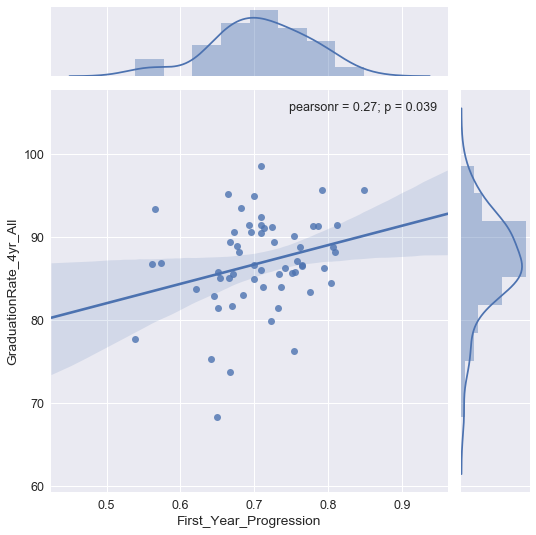

In [4]:
#find the correlaiton of first year progression and 150% grad rate
import seaborn as sns
#Create a function to plot regression lines for two variables
def PlotJoint(x,y,data):
    sns.set(context='notebook', style='darkgrid', font_scale=1.25)
    my_plot = sns.jointplot(x=x, y=y, data=data, kind="reg");
    my_plot.fig.set_figwidth(8)
    my_plot.fig.set_figheight(8)
    plt.show()
    
PlotJoint(NCCCData["First_Year_Progression"],NCCCData["Completers_150time_Grand total"],NCCCData) 
PlotJoint(NCCCData["First_Year_Progression"],NCCCData["GraduationRate_5yr_All"],NCCCData)
PlotJoint(NCCCData["First_Year_Progression"],NCCCData["GraduationRate_4yr_All"],NCCCData)

In [5]:
#Get describe stats on first year progression rate
NCCCData["First_Year_Progression"].describe()


count    59.000000
mean      0.708241
std       0.065048
min       0.539000
25%       0.668500
50%       0.708241
75%       0.754000
max       0.848000
Name: First_Year_Progression, dtype: float64

In [6]:
#find all first year success variables
delete_list=[]

for i in NCCCData.columns:
    if "1stYearSuccess" in i:
        delete_list.append(i)

In [7]:
#Remove all the target variables from the data set
#the number variables represent the passing rate for first time test takers on state mandated exams
#delete_list.extend(["First_Year_Progression","First_Year_Progression_ThreeGroups", "First_Year_Progression_TwoGroups","16-17","15-16","13-14","% SUCCESSFUL\r\n14-15",'13-Dec'])
delete_list.extend(["First_Year_Progression","16-17","15-16","13-14",'13-Dec'])
targets_dropped=NCCCData.drop(delete_list,axis=1)

In [8]:
#Split into train and test data
#Chose 75/25 train/test split
#x_train, x_test, y_train, y_test=train_test_split(targets_dropped,NCCCData["First_Year_Progression"],test_size=0.25, random_state=0)

#print("The train data set shape is: ",x_train.shape)
#print("The test data set shape is: ",x_test.shape)

x=targets_dropped
y=NCCCData["First_Year_Progression"]

In [9]:
#Use mean absolute error (MAE) to score the regression models created 
#(the scale of MAE is identical to the response variable)
#Function for Root mean squared error
#https://stackoverflow.com/questions/17197492/root-mean-square-error-in-python
def rmse(y_actual, y_predicted):
    return np.sqrt(mean_squared_error(y_actual, y_predicted))

#Function for Mean Absolute Percentage Error (MAPE) - Untested
#Adapted from - https://stackoverflow.com/questions/42250958/how-to-optimize-mape-code-in-python
def mape(y_actual, y_predicted): 
    mask = y_actual != 0
    return (np.fabs(y_actual - y_predicted)/y_actual)[mask].mean() * 100

#Create scorers for rmse and mape functions
mae_scorer = make_scorer(score_func=mean_absolute_error, greater_is_better=False)
rmse_scorer = make_scorer(score_func=rmse, greater_is_better=False)
mape_scorer = make_scorer(score_func=mape, greater_is_better=False)

#Make scorer array to pass into cross_validate() function for producing mutiple scores for each cv fold.
errorScoring = {'MAE':  mae_scorer, 
                'RMSE': rmse_scorer,
                'MAPE': mape_scorer
               }

In [10]:
def EvaluateRegressionEstimator(regEstimator, X, y, cv):
    
    scores = cross_validate(regEstimator, X, y, scoring=errorScoring, cv=cv, return_train_score=True)

    #cross val score sign-flips the outputs of MAE
    # https://github.com/scikit-learn/scikit-learn/issues/2439
    scores['test_MAE'] = scores['test_MAE'] * -1
    scores['test_MAPE'] = scores['test_MAPE'] * -1
    scores['test_RMSE'] = scores['test_RMSE'] * -1

    #print mean MAE for all folds 
    maeAvg = scores['test_MAE'].mean()
    print_str = "The average MAE for all cv folds is: \t\t\t {maeAvg:.5}"
    print(print_str.format(maeAvg=maeAvg))

    #print mean test_MAPE for all folds
    scores['test_MAPE'] = scores['test_MAPE']
    mape_avg = scores['test_MAPE'].mean()
    print_str = "The average MAE percentage (MAPE) for all cv folds is: \t {mape_avg:.5}"
    print(print_str.format(mape_avg=mape_avg))

    #print mean MAE for all folds 
    RMSEavg = scores['test_RMSE'].mean()
    print_str = "The average RMSE for all cv folds is: \t\t\t {RMSEavg:.5}"
    print(print_str.format(RMSEavg=RMSEavg))
    print('*********************************************************')

    print('Cross Validation Fold Mean Error Scores')
    scoresResults = pd.DataFrame()
    scoresResults['MAE'] = scores['test_MAE']
    scoresResults['MAPE'] = scores['test_MAPE']
    scoresResults['RMSE'] = scores['test_RMSE']
    return scoresResults

In [11]:
#Create a regression object and perform a grid search to find the best parameters
from sklearn.linear_model import ElasticNet

reg = ElasticNet(fit_intercept=True, normalize=True, precompute=True, copy_X=True
          , max_iter=10000, tol=0.0001, random_state=0)
 
#Test parameters
l1_ratio = [0.001, 0.01, 0.1, 0.5, 0.75, 1]
alpha = [0.001, 0.1, 1, 10]
selection = ['cyclic','random']
warm_start = [True, False]
parameters = {'l1_ratio': l1_ratio, 'alpha': alpha, 'selection': selection, 'warm_start': warm_start}

#Create a grid search object using the parameters above
from sklearn.model_selection import GridSearchCV
regGridSearch = GridSearchCV(estimator=reg
                   , n_jobs=8 # jobs to run in parallel
                   , verbose=1 # low verbosity
                   , param_grid=parameters
                   , cv=cv # KFolds = 10
                   , scoring=mae_scorer)

#Perform hyperparameter search to find the best combination of parameters for our data
regGridSearch.fit(x, y)

Fitting 10 folds for each of 96 candidates, totalling 960 fits


[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:  3.6min
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:  4.7min
[Parallel(n_jobs=8)]: Done 434 tasks      | elapsed:  4.9min
[Parallel(n_jobs=8)]: Done 784 tasks      | elapsed:  5.0min
[Parallel(n_jobs=8)]: Done 960 out of 960 | elapsed:  5.0min finished


GridSearchCV(cv=ShuffleSplit(n_splits=10, random_state=0, test_size=0.1, train_size=None),
       error_score='raise',
       estimator=ElasticNet(alpha=1.0, copy_X=True, fit_intercept=True, l1_ratio=0.5,
      max_iter=10000, normalize=True, positive=False, precompute=True,
      random_state=0, selection='cyclic', tol=0.0001, warm_start=False),
       fit_params=None, iid=True, n_jobs=8,
       param_grid={'l1_ratio': [0.001, 0.01, 0.1, 0.5, 0.75, 1], 'alpha': [0.001, 0.1, 1, 10], 'selection': ['cyclic', 'random'], 'warm_start': [True, False]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=make_scorer(mean_absolute_error, greater_is_better=False),
       verbose=1)

In [12]:
#Create a regression estimator with best parameters for cross validation
regEstimator = regGridSearch.best_estimator_
eNET=regEstimator.fit(x,y)

The average MAE for all cv folds is: 			 0.039132
The average MAE percentage (MAPE) for all cv folds is: 	 5.8715
The average RMSE for all cv folds is: 			 0.048814
*********************************************************
Cross Validation Fold Mean Error Scores
        MAE       MAPE      RMSE
0  0.053416   8.133154  0.061758
1  0.023380   3.118134  0.031197
2  0.066798  10.336276  0.074437
3  0.035508   5.450225  0.050747
4  0.031060   4.339924  0.037310
5  0.039391   6.662138  0.061789
6  0.043933   6.734190  0.053145
7  0.032695   4.496845  0.037589
8  0.041606   5.899909  0.045566
9  0.023532   3.544496  0.034599


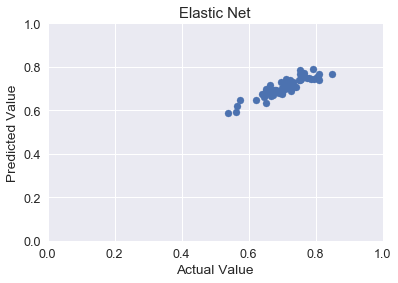

In [13]:
print(EvaluateRegressionEstimator(eNET,x,y,cv))

plt.scatter(y,eNET.predict(x))
plt.title("Elastic Net")
plt.xlabel("Actual Value")
plt.ylabel("Predicted Value")
plt.ylim(0,1)
plt.xlim(0,1)
plt.show()

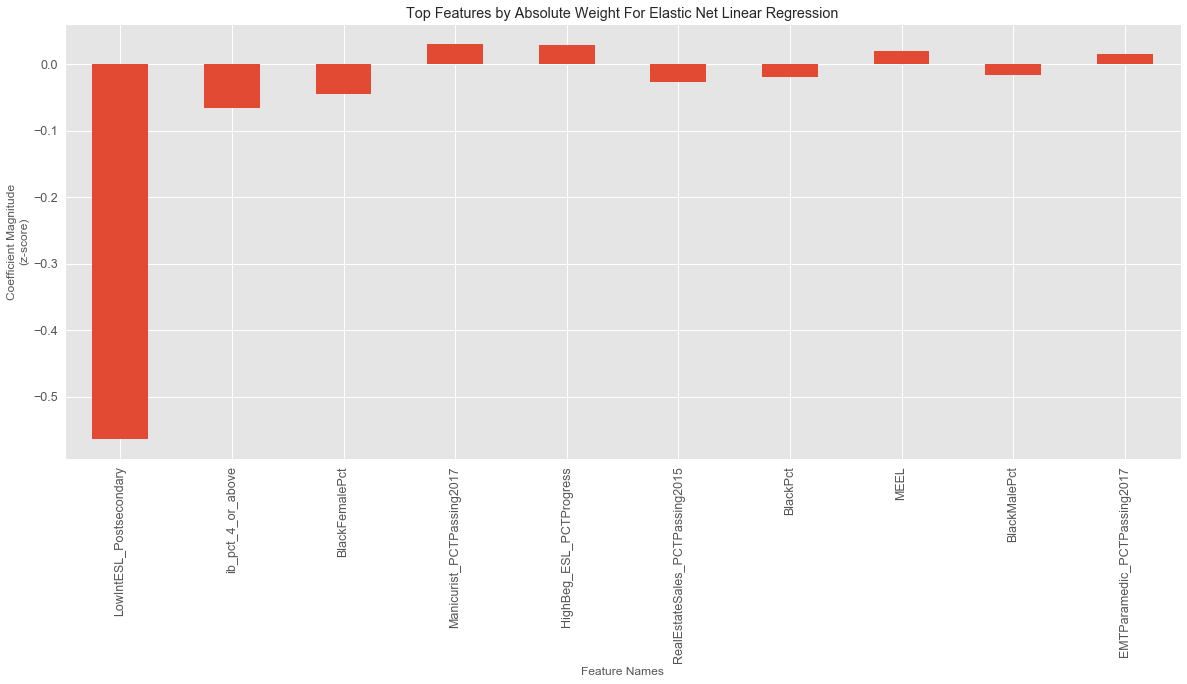

In [14]:
#Load the model's coefficient weights and feature names into a dataframe sorted by weights
weights = eNET.coef_
feature_names = x.columns.values
ft_imp_df = pd.DataFrame({'feature_names':feature_names, 'weights':weights, 'absolute_weights': np.abs(weights)})
ft_imp_df.sort_values(by='absolute_weights', inplace=True, ascending=False )

# Examine categorical variables of interest  
import matplotlib.pyplot as plt
%matplotlib inline

#Plot the model's feature importances
# REFERENCE:  Eric Larson, https://github.com/eclarson/DataMiningNotebooks
plt.style.use('ggplot')

wt_plt_df = ft_imp_df.head(10)

weights = pd.Series(wt_plt_df['weights'].values,index=wt_plt_df['feature_names'])
ax = weights.plot(kind='bar', figsize=(20,8))

ax.set_title("Top Features by Absolute Weight For Elastic Net Linear Regression")
ax.set_ylabel("Coefficient Magnitude\n(z-score)")
ax.set_xlabel("Feature Names")
plt.show()

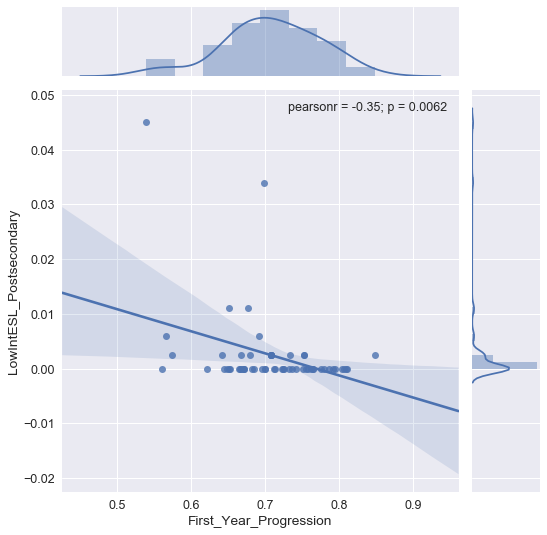

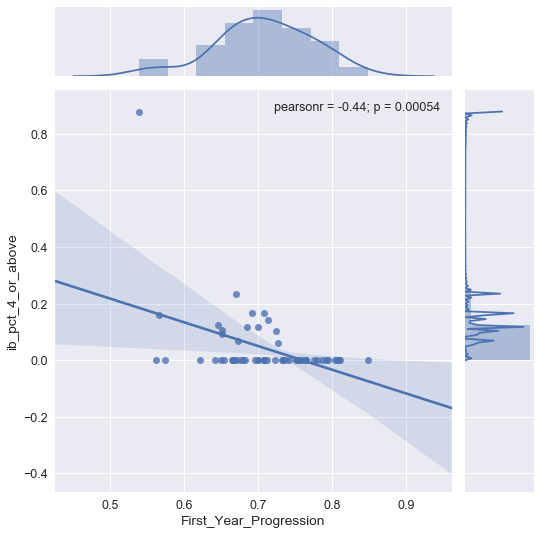

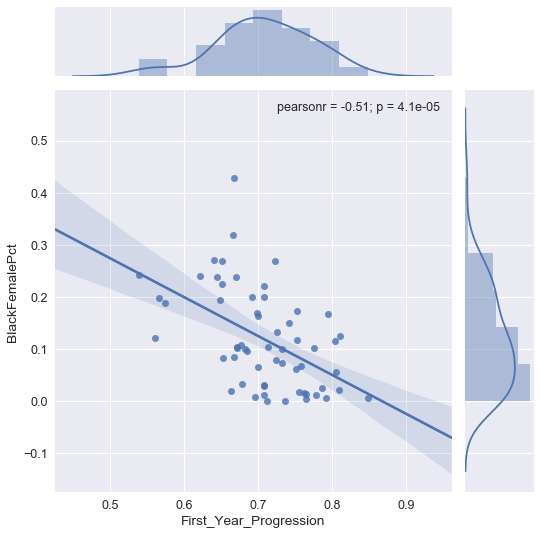

In [15]:
#scatter plots of the top 3 variables
PlotJoint(NCCCData["First_Year_Progression"],NCCCData["LowIntESL_Postsecondary"],NCCCData) 
PlotJoint(NCCCData["First_Year_Progression"],NCCCData["ib_pct_4_or_above"],NCCCData) 
PlotJoint(NCCCData["First_Year_Progression"],NCCCData["BlackFemalePct"],NCCCData) 

#postsecondary (CC data) is individual left th eprogram and was found to have enrolled in a post secondary institution.
#ib (HS data) is Percentage of IB Exams with Scores of 4 or Above at the School level
#The International Baccalaureate® (IB) assesses student work as direct evidence of achievement against the stated goals of the Diploma Programme (DP) courses.
#blackfemalepct (HS data)